In [3]:
import sys, os
sys.path.append(os.path.abspath(".."))


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing import (
    load_data, clean_fraud_data,
    prepare_ip_data, merge_ip_country
)
from src.feature_engineering import (
    add_time_features, add_transaction_velocity
)

fraud_path = "../data/raw/Fraud_Data.csv"
ip_path = "../data/raw/IpAddress_to_Country.csv"

fraud_df, ip_df = load_data(fraud_path, ip_path)


In [5]:
fraud_df = clean_fraud_data(fraud_df)
ip_df = prepare_ip_data(ip_df)

fraud_df.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


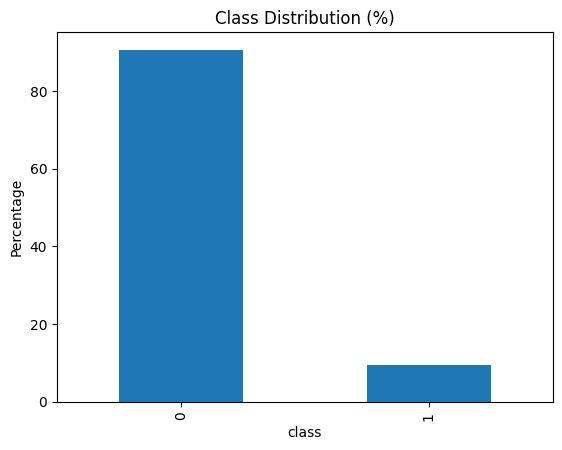

class
0    90.635423
1     9.364577
Name: proportion, dtype: float64

In [6]:
class_counts = fraud_df['class'].value_counts(normalize=True) * 100
class_counts.plot(kind='bar')
plt.title("Class Distribution (%)")
plt.ylabel("Percentage")
plt.show()

class_counts


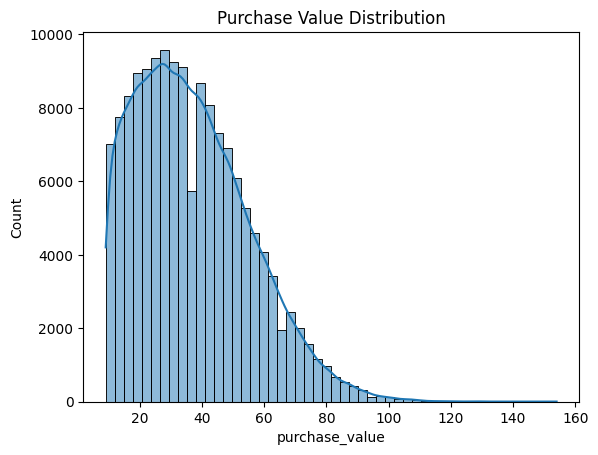

In [7]:
sns.histplot(
    fraud_df['purchase_value'],
    bins=50,
    kde=True
)
plt.title("Purchase Value Distribution")
plt.show()


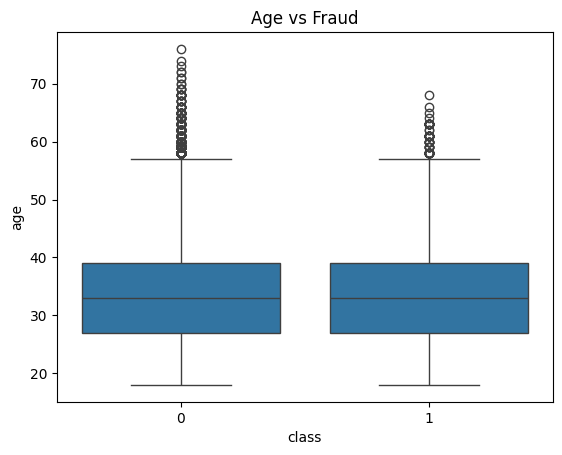

In [8]:
sns.boxplot(
    x='class',
    y='age',
    data=fraud_df
)
plt.title("Age vs Fraud")
plt.show()
